# 2. Machine Learning for Regression

In [1]:
import pandas as pd
import numpy as np

## 2.1 Data preparation 

In [2]:
!wget 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'

In [3]:
df = pd.read_csv('AB_NYC_2019.csv') 
active_cols = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
df = df[active_cols]

## 2.2 Exploratory Data Analysis 

In [4]:
df.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:xlabel='price', ylabel='Count'>

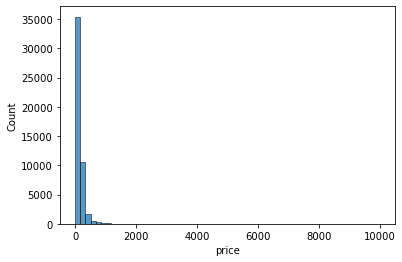

In [6]:
sns.histplot(df.price, bins=60)

<AxesSubplot:xlabel='price', ylabel='Count'>

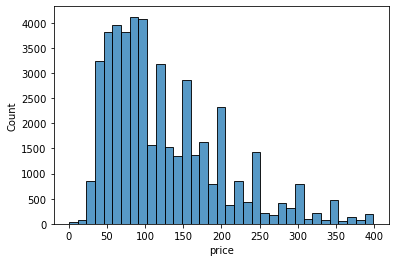

In [7]:
sns.histplot(df.price[df.price < 400], bins=35)

### Question 1: Number of missing values

In [8]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

### Question 2: Median for minimum_nights

In [9]:
df.minimum_nights.median()

3.0

In [10]:
df.minimum_nights.quantile()

3.0

## 2.3 Setting up the validation framework 

In [11]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [12]:
n_val, n_test, n_train

(9779, 9779, 29337)

In [13]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]
len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

In [16]:
del df_train['price']
del df_val['price']
del df_test['price']

## 2.4 Data cleaning 

### Question 3: Best way to fill NAs

In [17]:
df_train.isnull().sum()

latitude                             0
longitude                            0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 5998
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [18]:
rpm_mean = df_train.reviews_per_month.mean()

In [19]:
df_train_norm_0 = df_train.fillna(0)

In [20]:
df_train_norm_mean = df_train.fillna(rpm_mean)

### Utilities - 1

In [21]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def impute_missing_values(df, value):
    return df.fillna(value)

In [22]:
w0_0, w_0 = train_linear_regression(df_train_norm_0, y_train)
w0_mean, w_mean = train_linear_regression(df_train_norm_mean, y_train)

In [23]:
df_val_0 = df_val.fillna(0)
df_val_0.isnull().sum()

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [24]:
df_val_mean = df_val.fillna(rpm_mean) # tried mean of df_val as well
df_val_mean.isnull().sum()

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [25]:
y_0_pred = w0_0 + df_val_0.dot(w_0)
score_0 = rmse(y_val, y_0_pred)
round(score_0, 2)

0.64

In [26]:
y_mean_pred = w0_mean + df_val_mean.dot(w_mean)
score_mean = rmse(y_val, y_mean_pred)
round(score_mean, 2)

0.64

## 2.5 Model training and tuning

### Utilities - 2 

In [27]:
del df_train
del df_test
del df_val

In [28]:
def split(df, seed):
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)
    
    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    return {"train":[df_train, y_train], "val":[df_val, y_val], "test":[df_test, y_test]}

def predict(w0, w, val_features):
    return w0 + val_features.dot(w)

def split_train_test(df, seed, r):
    # prepare
    df = impute_missing_values(df, 0)
    
    # split
    datasets = split(df, seed)
    train = datasets["train"]
    val = datasets["val"]
    
    # train
    if r is not None:
        w0, w = train_linear_regression_reg(train[0], train[1], r)
    else:
        w0, w = train_linear_regression(train[0], train[1])
    
    # validate
    y_pred = predict(w0, w, val[0])
    score = rmse(val[1], y_pred)
    
    print("{}\t\t{}\t\t{}".format(seed, r, round(score,2)))
    return w0, w, r, score

### Question 4: Best regularization parameter r 

In [29]:
print("seed\t\tr\t\tRMSE")
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    split_train_test(df, 42, r)

seed		r		RMSE
42		0		0.64
42		1e-06		0.64
42		0.0001		0.64
42		0.001		0.64
42		0.01		0.66
42		0.1		0.68
42		1		0.68
42		5		0.68
42		10		0.68


### Question 5: STD of RMSE scores for different seeds 

In [30]:
print("seed\t\tr\t\tRMSE")
scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    [w0, w, r, score] = split_train_test(df, seed, None)
    scores.append(score)

print(scores)
scores_std = np.std(scores)
print("\nStd RMSE: ", round(scores_std, 3))

seed		r		RMSE
0		None		0.65
1		None		0.65
2		None		0.65
3		None		0.64
4		None		0.64
5		None		0.63
6		None		0.63
7		None		0.65
8		None		0.65
9		None		0.64
[0.6549779961365334, 0.6462523685579471, 0.647655817759481, 0.6375145070819092, 0.6445809082983165, 0.6305809996428803, 0.6297851917103146, 0.6506184266843087, 0.6489780353328034, 0.6437565168218954]

Std RMSE:  0.008


## 2.5 Using the model

### Question 6: RMSE on test  

In [31]:
df = pd.read_csv('AB_NYC_2019.csv')
active_cols = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
df = df[active_cols]

df = impute_missing_values(df, 0) # Fill the missing values with 0

datasets = split(df, 9) # Split the dataset like previously, use seed 9

train = datasets["train"]
val = datasets["val"]
test = datasets["test"]

X_full_train = pd.concat([train[0], val[0]]) # Combine train and validation datasets
y_full_train = np.concatenate([train[1], val[1]])

w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001) # Train a model with r=0.001

y_pred = w0 + test[0].dot(w)
score = rmse(test[1], y_pred) # RMSE on the test dataset

print("RMSE on the test dataset: ", round(score,2))

RMSE on the test dataset:  0.65
